In [ ]:
# Setup imports and path so `src` package is importable
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import logging
# Reduce TensorFlow logging to suppress known deprecation warnings from TF and TFP
# Set C++ minimal log level (0=all,1=INFO,2=WARNING,3=ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# Reduce Python-side TensorFlow logger verbosity
try:
    tf.get_logger().setLevel(logging.ERROR)
    logging.getLogger('tensorflow').setLevel(logging.ERROR)
    # Also set v1 logging verbosity if available
    tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
except Exception:
    pass

# ensure the project root is on sys.path so `src` is importable
# project_root = r"C:\Users\yecha\workspace\JPMSummer"
# if project_root not in sys.path:
#     sys.path.insert(0, project_root)

from src.data.data import SSMData, StochasticVariationalData
from src.models.KalmanFilter import KalmanFilter
from src.models.ExtendedKalmanFilter import ExtendedKalmanFilter
from src.models.UnscentedKalmanFilter import UnscentedKalmanFilter
from src.models.ParticleFilter import ParticleFilter

import tensorflow_probability as tfp
tfd = tfp.distributions

tf.random.set_seed(1)
np.random.seed(1)

## 1) Multidimensional linear Gaussian SSM and Kalman Filter

We construct a 2D constant-velocity system (state = [position, velocity]) and observe position and velocity with noise.

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


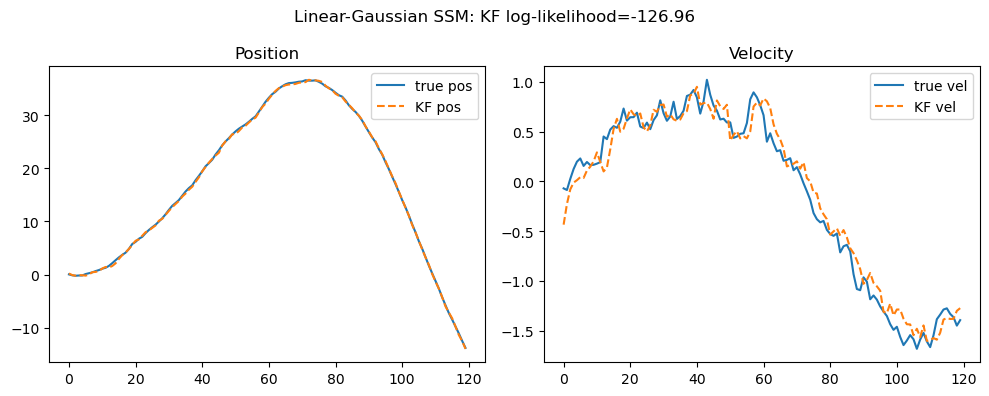

In [2]:
# Build a simple 2D constant-velocity model
dt = 1.0
A = np.array([[1.0, dt], [0.0, 1.0]], dtype=float)  # transition
H = np.eye(2, dtype=float)  # observe both states
Q = np.eye(2, dtype=float) * 0.01  # small process noise
R = np.eye(2, dtype=float) * 0.1   # observation noise

T = 120
initial_mean = np.zeros((2,))
initial_cov = np.eye(2) * 1.0

ssm = SSMData(
    transition_matrix=A,
    observation_matrix=H,
    transition_cov=Q,
    observation_cov=R,
    initial_mean=initial_mean,
    initial_cov=initial_cov,
    dtype=tf.float64,
)

x_true_tf, y_tf = ssm.sample(num_steps=T, seed=42)
# Convert to numpy for plotting/feeding non-tf filters
x_true = x_true_tf.numpy()  # shape (T+1, state_dim)
y = y_tf.numpy()            # shape (T, obs_dim)

# Run Kalman Filter
kf = KalmanFilter(
    transition_matrix=A,
    observation_matrix=H,
    transition_cov=Q,
    observation_cov=R,
    initial_mean=initial_mean,
    initial_cov=initial_cov,
)

filtered_means_tf, filtered_covs_tf, ll = kf.filter(tf.convert_to_tensor(y, dtype=tf.float64))
filtered_means = filtered_means_tf.numpy()

# Plot true vs filtered
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x_true[1:, 0], label='true pos')
plt.plot(filtered_means[:, 0], '--', label='KF pos')
plt.title('Position')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(x_true[1:, 1], label='true vel')
plt.plot(filtered_means[:, 1], '--', label='KF vel')
plt.title('Velocity')
plt.legend()
plt.suptitle(f'Linear-Gaussian SSM: KF log-likelihood={float(ll):.2f}')
plt.tight_layout()
plt.show()

## 2) Generate stochastic variational dataset

We use the `StochasticVariationalData` class (1D) added to `data.py`.
Model (1D):
- X_k = alpha * X_{k-1} + sigma * eta_k  (eta_k ~ N(0,1))
- Y_k = beta * exp(X_k / 2) * epsilon_k (epsilon_k ~ N(0,1))

We'll simulate a series and visualize the latent log-volatility X and observations Y.

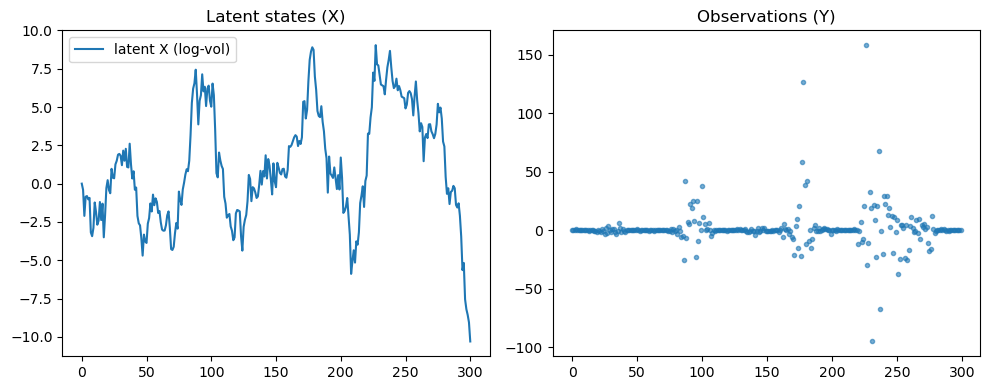

In [3]:
# Parameters for stochastic variational (stochastic volatility-like) model
alpha = 0.98
sigma = 1
beta = 1.0
T_sv = 300

sv = StochasticVariationalData(alpha=alpha, sigma=sigma, beta=beta, initial_state=0.0, dtype=tf.float64)
x_sv_tf, y_sv_tf = sv.sample(num_steps=T_sv, seed=42)
x_sv = x_sv_tf.numpy().squeeze()  # shape (T+1,)
y_sv = y_sv_tf.numpy().squeeze()  # shape (T,)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(x_sv, label='latent X (log-vol)')
# plt.xlabel('(log-vol)')
plt.title('Latent states (X)')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_sv, '.', alpha=0.6)
plt.title('Observations (Y)')
plt.tight_layout()
plt.show()

In [4]:
print(x_sv)

[  0.          -0.40061101  -2.10448079  -0.85329546  -0.80941721
  -1.02544538  -0.93092914  -3.1821694   -3.42918232  -2.88870706
  -1.23003597  -1.85125557  -2.68126417  -2.42238158  -1.19970504
  -2.37544324  -1.30602753  -3.50178431  -2.06746506  -0.28648745
   0.22598412  -0.41668899  -0.62815351   0.96622337   0.38662281
   0.34934439   1.25725846   1.49234314   1.8904849    1.93939371
   1.81791362   1.20387911   2.15491284   1.49567606   2.27359645
   1.09163465   1.05689621   2.60650983   1.26573735   0.33459645
   0.80588925  -0.39800963  -0.25394965  -2.11051004  -2.5876515
  -2.72370046  -3.55884592  -4.69714893  -3.32620075  -3.77692728
  -3.86981037  -2.61021504  -2.24790563  -1.2924877   -1.81655332
  -0.71638091  -1.40592675  -0.95927006  -1.19375592  -1.91454278
  -1.786703    -2.51623786  -2.99748115  -3.07197949  -3.05977663
  -2.71542205  -2.06526791  -1.81207293  -2.87356473  -4.27245759
  -4.32953196  -4.12025931  -3.21928774  -2.56468398  -2.93755617
  -0.519022

## 3) Apply EKF & UKF to stochastic variational data (approximation)

We construct deterministic functions:
- f(x) = alpha * x  (transition mean)
- h(x) = beta * exp(x / 2)  (observation *scale* so actual observation is h(x) * epsilon)

Both EKF and UKF implementations assume additive observation noise y = h(x) + r with fixed covariance R. For this experiment we approximate the observation noise with a fixed scalar variance chosen as the empirical mean of beta^2 * exp(x). This is an approximation to make EKF/UKF run without changing their APIs. Particle filter (next) will use multiplicative noise naturally.

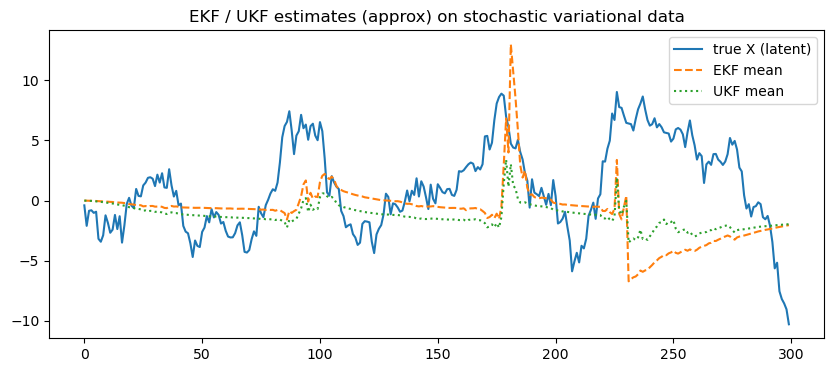

EKF log-likelihood (approx): -1296.08
UKF log-likelihood (approx): -1280.99


In [5]:
import tensorflow as tf

# Build deterministic wrappers for TF-based filters
def f_tf(x: tf.Tensor) -> tf.Tensor:
    return tf.cast(alpha, dtype=tf.float64) * x

def h_tf(x: tf.Tensor) -> tf.Tensor:
    return tf.cast(beta, dtype=tf.float64) * tf.exp(x / 2.0)

# Approximate observation covariance R by using empirical average variance
emp_R = float((beta ** 2) * np.mean(np.exp(x_sv)))
R_approx = np.array([[emp_R]], dtype=float)
Q_approx = np.array([[sigma ** 2]], dtype=float)  # process noise covariance (1D)

# Initial conditions
initial_mean_1d = np.array([0.0])
initial_cov_1d = np.array([[1.0]])

# Create EKF and UKF instances
ekf = ExtendedKalmanFilter(
    f=f_tf,
    h=h_tf,
    Q=tf.constant(Q_approx, dtype=tf.float64),
    R=tf.constant(R_approx, dtype=tf.float64),
    initial_mean=tf.constant(initial_mean_1d, dtype=tf.float64),
    initial_cov=tf.constant(initial_cov_1d, dtype=tf.float64),
)

ukf = UnscentedKalmanFilter(
    f=f_tf,
    h=h_tf,
    Q=tf.constant(Q_approx, dtype=tf.float64),
    R=tf.constant(R_approx, dtype=tf.float64),
    initial_mean=tf.constant(initial_mean_1d, dtype=tf.float64),
    initial_cov=tf.constant(initial_cov_1d, dtype=tf.float64),
)

# Run EKF and UKF on the observations
obs = tf.convert_to_tensor(y_sv.reshape(-1, 1), dtype=tf.float64)

ekf_means_tf, ekf_covs_tf, ekf_ll = ekf.filter(obs)
ukf_means_tf, ukf_covs_tf, ukf_ll = ukf.filter(obs)

ekf_means = ekf_means_tf.numpy().squeeze()
ukf_means = ukf_means_tf.numpy().squeeze()

plt.figure(figsize=(10, 4))
plt.plot(x_sv[1:], label='true X (latent)')
plt.plot(ekf_means, '--', label='EKF mean')
plt.plot(ukf_means, ':', label='UKF mean')
plt.legend()
plt.title('EKF / UKF estimates (approx) on stochastic variational data')
plt.show()

print(f"EKF log-likelihood (approx): {float(ekf_ll):.2f}")
print(f"UKF log-likelihood (approx): {float(ukf_ll):.2f}")

## 4) Particle Filter on the stochastic variational data

The Particle Filter can directly handle multiplicative observation noise by using the deterministic observation function `h(x) = beta * exp(x/2)` and evaluating the likelihood p(y | x) = Normal(loc=0, scale=h(x)). We'll set a reasonably large number of particles for stability.

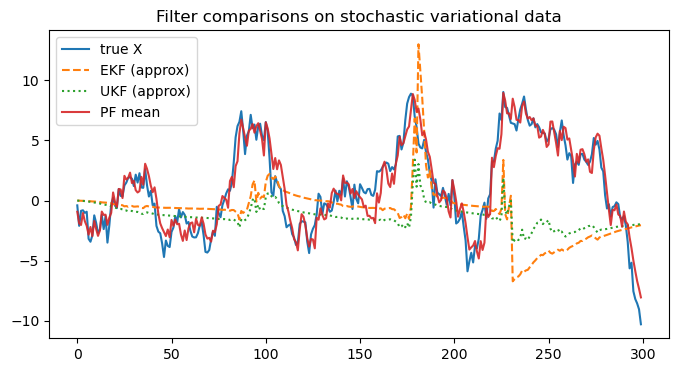

PF approx log-likelihoods (sum): -698.75
Mean RMSEs vs true X (1..T): EKF=5.037, UKF=4.591, PF=1.184


In [6]:
import tensorflow as tf

# Define transition and observation wrappers for PF
def f_pf(x: tf.Tensor) -> tf.Tensor:
    return tf.cast(alpha, dtype=tf.float64) * x

def h_pf(x: tf.Tensor) -> tf.Tensor:
    # We return the *mean* of the observation, using zero-mean multiplicative noise model.
    # ParticleFilter expects h(x) to return the deterministic observation; it then assumes additive R.
    # To handle multiplicative noise we will instead compute likelihoods manually inside ParticleFilter.update
    return tf.zeros((1,), dtype=tf.float64)  # placeholder: ParticleFilter.update uses preds and R

# We'll create a custom PF instance but monkeypatch update to use multiplicative noise likelihood.
num_particles = 2000

# Initialize PF with a tiny R (we will override likelihood computation below)
pf = ParticleFilter(
    transition_fn=f_pf,
    observation_fn=lambda x: tf.cast(beta, dtype=tf.float64) * tf.exp(x/2.0),
    Q=Q_approx,
    R=np.array([[1.0]]),  # placeholder
    num_particles=num_particles,
    initial_mean=tf.constant([0.0], dtype=tf.float64),
    initial_cov=tf.constant([[1.0]], dtype=tf.float64),
    seed=7,
)

# We'll run the PF step-by-step, but override the likelihood evaluation to use y ~ N(0, (beta*exp(x/2))^2)
est_means = []
est_covs = []
logliks = []

for t in range(T_sv):
    # Predict
    pf.predict()

    # Evaluate multiplicative-noise likelihood manually
    # particles: shape (N, state_dim) where state_dim==1
    particles = pf.particles  # tensor shape (N, 1)
    # Compute scale = beta * exp(x/2) per particle
    scales = tf.squeeze(tf.cast(beta, tf.float64) * tf.exp(particles[:, 0] / 2.0))  # shape (N,)

    # Compute particle-wise log-likelihood under N(0, scale^2)
    y_t = float(y_sv[t])
    # compute log pdf: -0.5*log(2*pi*scale^2) - 0.5*(y^2/scale^2)
    log_likes = -0.5 * tf.math.log(2.0 * np.pi * (scales ** 2)) - 0.5 * (y_t ** 2) / (scales ** 2)

    # Update log weights using these log_likes
    new_log_w = pf.log_weights + tf.cast(log_likes, dtype=pf.dtype)
    log_norm_const = tf.reduce_logsumexp(new_log_w)
    normalized_log_w = new_log_w - log_norm_const
    pf.log_weights = normalized_log_w

    # ESS and resample as in ParticleFilter.update
    weights = tf.exp(pf.log_weights)
    ess = 1.0 / tf.reduce_sum(weights ** 2)
    pf.last_ess = ess
    try:
        pf.ess_history.append(float(ess.numpy()))
        pf.weights_history.append(weights.numpy())
    except Exception:
        pf.ess_history.append(float(ess))
        pf.weights_history.append(weights)

    threshold = tf.cast(pf.num_particles / 2.0, dtype=pf.dtype)
    if ess < threshold:
        idx = pf._systematic_resample(weights)
        pf.particles = tf.gather(pf.particles, idx)
        pf.log_weights = tf.fill([pf.num_particles], tf.math.log(1.0 / tf.cast(pf.num_particles, pf.dtype)))

    # Estimate
    mean, cov = pf.estimate()
    est_means.append(float(mean.numpy()[0]))
    est_covs.append(cov.numpy())
    logliks.append(float(log_norm_const.numpy()))

est_means = np.array(est_means)

plt.figure(figsize=(8, 4))
plt.plot(x_sv[1:], label='true X')
plt.plot(ekf_means, '--', label='EKF (approx)')
plt.plot(ukf_means, ':', label='UKF (approx)')
plt.plot(est_means, alpha=0.9, label='PF mean')
plt.legend()
plt.title('Filter comparisons on stochastic variational data')
plt.show()

print(f"PF approx log-likelihoods (sum): {np.sum(logliks):.2f}")
print(f"Mean RMSEs vs true X (1..T): EKF={np.sqrt(np.mean((ekf_means - x_sv[1:])**2)):.3f}, UKF={np.sqrt(np.mean((ukf_means - x_sv[1:])**2)):.3f}, PF={np.sqrt(np.mean((est_means - x_sv[1:])**2)):.3f}")

**Notes & Next steps**

- EKF/UKF were used with a fixed observation covariance `R` (approximation). For a correct EKF/UKF treatment one would need to incorporate state-dependent observation covariance or transform the model into an additive-noise form.
- Particle Filter handles the multiplicative noise directly by evaluating particle-wise likelihoods using scale = `beta * exp(x/2)`.
- You can tune `num_particles`, `Q`, `R`, and initial priors to trade off computation vs accuracy.
- If you'd like, I can add small unit tests for `StochasticVariationalData`, or integrate this notebook into `kalman_filter_demo.ipynb`.